In [1]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import rankdata, genpareto
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.stats.diagnostic import acorr_ljungbox
import seaborn as sns
from arch import arch_model
import scipy.stats as stats

In [2]:
df_cleaned = pd.read_excel("Saudi_Brent.xlsx")

In [3]:
# Drop rows where both 'Close_cac' and 'Brent_Euro' are NaN
df = df_cleaned.dropna(how='all', subset=['Close_nifty', 'Brent_INR'])

In [4]:
missing_values = df.isnull().sum()
print(missing_values)

Date             0
Close_nifty    545
Brent_INR      309
dtype: int64


In [5]:
#Define the date ranges
pre_covid_start = '2015-01-01'
pre_covid_end = '2020-02-29'
covid_start = '2020-03-01'
covid_end = '2022-02-28'
post_covid_start = '2022-03-01'
post_covid_end = '2024-03-31'

In [6]:
# Filter the data
pre_covid_data = df[(df['Date'] >= pre_covid_start) & (df['Date'] <= pre_covid_end)]
covid_data = df[(df['Date'] >= covid_start) & (df['Date'] <= covid_end)]
post_covid_data = df[(df['Date'] >= post_covid_start) & (df['Date'] <= post_covid_end)]

In [7]:
missing_values = post_covid_data.isnull().sum()
print(missing_values)

Date             0
Close_nifty    124
Brent_INR      110
dtype: int64


In [8]:
# Forward fill missing values
post_covid_data.fillna(method='ffill', inplace=True)

C:\Users\KASHISH NIGAM\AppData\Local\Temp\ipykernel_19676\2437016192.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  post_covid_data.fillna(method='ffill', inplace=True)


In [9]:
missing_values = post_covid_data.isnull().sum()
print(missing_values)

Date           0
Close_nifty    0
Brent_INR      0
dtype: int64


In [10]:
post_covid_data.head()

,Date,Close_nifty,Brent_INR
2016,2022-03-01,12674.339844,416.521961
2017,2022-03-02,12654.650391,446.598053
2018,2022-03-03,12756.309570,433.155804
2019,2022-03-04,12756.309570,465.071757
2020,2022-03-06,12804.219727,465.071757


In [11]:
post_covid_data = post_covid_data[post_covid_data['Date'] != '2022-03-01']

# Display cleaned DataFrame
print("\nDataFrame after deleting the row with Date '2020-03-01':")
print(post_covid_data)


DataFrame after deleting the row with Date '2020-03-01':
           Date   Close_nifty   Brent_INR
2017 2022-03-02  12654.650391  446.598053
2018 2022-03-03  12756.309570  433.155804
2019 2022-03-04  12756.309570  465.071757
2020 2022-03-06  12804.219727  465.071757
2021 2022-03-07  12808.030273  484.446618
...         ...           ...         ...
2648 2024-03-25  12656.940430  323.225674
2649 2024-03-26  12585.540039  322.213015
2650 2024-03-27  12607.980469  318.574945
2651 2024-03-28  12565.889648  323.188168
2652 2024-03-31  12401.559570  323.188168

[634 rows x 3 columns]


## ADF TEST

In [12]:
time_series_columns = ['Close_nifty', 'Brent_INR']

def adf_test(timeseries):
    result = adfuller(timeseries, autolag='AIC')
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value}')

# Loop over each column and perform ADF test
for column in time_series_columns:
    print(f"ADF Test Results for {column}:")
    adf_test(post_covid_data[column])
    print()

ADF Test Results for Close_nifty:
ADF Statistic: -2.114716779651525
p-value: 0.23863823489309854
Critical Values:
   1%: -3.440958441424668
   5%: -2.86622052433566
   10%: -2.569262629991048

ADF Test Results for Brent_INR:
ADF Statistic: -2.236707969962088
p-value: 0.19319326789850488
Critical Values:
   1%: -3.440822526288827
   5%: -2.8661606613087542
   10%: -2.5692307337540603



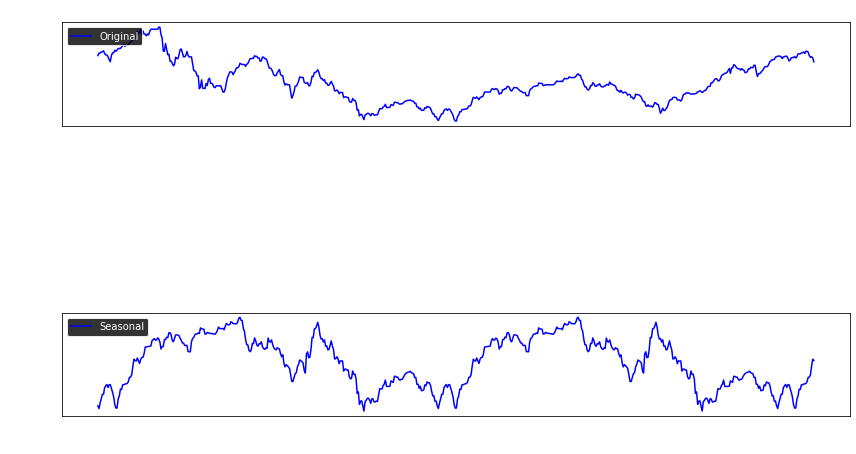

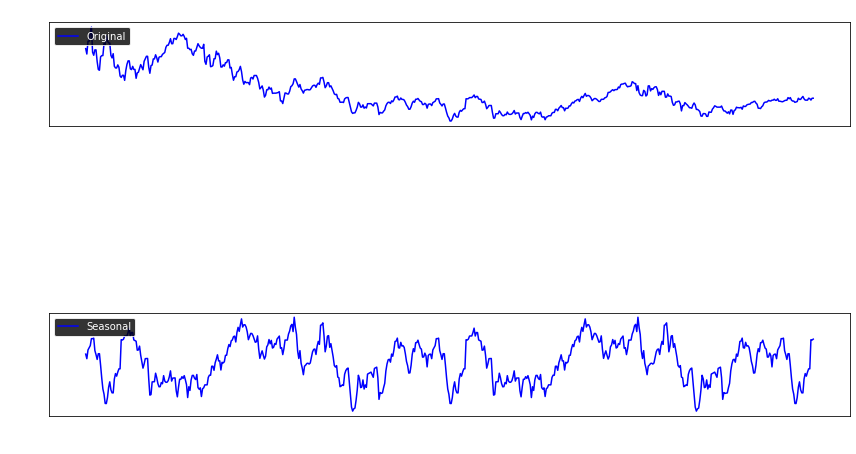

In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Decompose the time series for Close_nifty
result_nifty = seasonal_decompose(post_covid_data['Close_nifty'], model='additive', period=300)

# Plot the decomposed components for Close_nifty
plt.figure(figsize=(12, 8))

plt.subplot(411)
plt.plot(post_covid_data['Close_nifty'], label='Original', color='blue')
plt.legend(loc='upper left', facecolor='black', edgecolor='white', labelcolor='white')
plt.ylabel('Original', color='white')
plt.tick_params(axis='x', colors='white')
plt.tick_params(axis='y', colors='white')
plt.title('Time Series Decomposition - Close_nifty', color='white')

plt.subplot(413)
plt.plot(result_nifty.seasonal, label='Seasonal', color='blue')
plt.legend(loc='upper left', facecolor='black', edgecolor='white', labelcolor='white')
plt.ylabel('Seasonal', color='white')
plt.tick_params(axis='x', colors='white')
plt.tick_params(axis='y', colors='white')
plt.xlabel('Date', color='white')

plt.tight_layout()
plt.show()

# Decompose the time series for Brent_INR
result_brent = seasonal_decompose(post_covid_data['Brent_INR'], model='additive', period=300)

# Plot the decomposed components for Brent_INR
plt.figure(figsize=(12, 8))

plt.subplot(411)
plt.plot(post_covid_data['Brent_INR'], label='Original', color='blue')
plt.legend(loc='upper left', facecolor='black', edgecolor='white', labelcolor='white')
plt.ylabel('Original', color='white')
plt.tick_params(axis='x', colors='white')
plt.tick_params(axis='y', colors='white')
plt.title('Time Series Decomposition - Brent_INR', color='white')

plt.subplot(413)
plt.plot(result_brent.seasonal, label='Seasonal', color='blue')
plt.legend(loc='upper left', facecolor='black', edgecolor='white', labelcolor='white')
plt.ylabel('Seasonal', color='white')
plt.tick_params(axis='x', colors='white')
plt.tick_params(axis='y', colors='white')
plt.xlabel('Date', color='white')

plt.tight_layout()
plt.show()


#### SUMMARY

In [14]:
summary = post_covid_data.describe()
print(summary)

        Close_nifty   Brent_INR
count    634.000000  634.000000
mean   11587.861941  339.938285
std      862.458911   52.185232
min     9976.650391  266.482896
25%    10949.419922  303.437092
50%    11458.980469  321.904205
75%    12198.712646  361.833037
max    13820.349609  500.066661


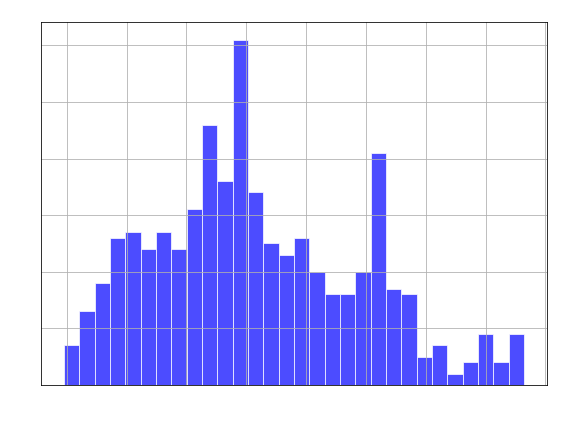

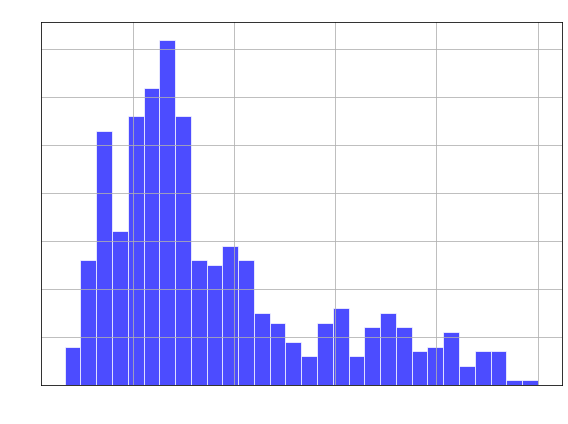

In [15]:
import matplotlib.pyplot as plt

# Plot histogram for 'Close_nifty'
plt.figure(figsize=(8, 6))
plt.hist(post_covid_data['Close_nifty'], bins=30, color='blue', edgecolor='white', alpha=0.7)

# Add labels and title
plt.xlabel('Close_nifty', color='white')
plt.ylabel('Frequency', color='white')
plt.title('Histogram of Close_nifty', color='white')

# Customize tick parameters to be white
plt.tick_params(axis='x', colors='white')
plt.tick_params(axis='y', colors='white')

# Show grid and plot
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot histogram for 'Brent_INR'
plt.figure(figsize=(8, 6))
plt.hist(post_covid_data['Brent_INR'], bins=30, color='blue', edgecolor='white', alpha=0.7)

# Add labels and title
plt.xlabel('Brent_INR', color='white')
plt.ylabel('Frequency', color='white')
plt.title('Histogram of Brent_INR', color='white')

# Customize tick parameters to be white
plt.tick_params(axis='x', colors='white')
plt.tick_params(axis='y', colors='white')

# Show grid and plot
plt.grid(True)
plt.tight_layout()
plt.show()

In [16]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller, kpss
# Augmented Dickey-Fuller Test
def adf_test(series, title=''):
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series, autolag='AIC')
    labels = ['ADF Statistic', 'p-value', '#Lags Used', 'Number of Observations Used']
    out = pd.Series(result[:4], index=labels)
    for key, value in result[4].items():
        out[f'Critical Value ({key})'] = value
    print(out)
    print('')

# KPSS Test
def kpss_test(series, title=''):
    print(f'KPSS Test: {title}')
    result = kpss(series, regression='c', nlags="auto")
    labels = ['KPSS Statistic', 'p-value', 'Lags Used']
    out = pd.Series(result[:3], index=labels)
    for key, value in result[3].items():
        out[f'Critical Value ({key})'] = value
    print(out)
    print('')

In [17]:
post_covid_data = post_covid_data.copy()
post_covid_data['Log_Return_Close_nifty'] = np.log(post_covid_data['Close_nifty'] / post_covid_data['Close_nifty'].shift(1))
post_covid_data['Log_Return_Brent_INR'] = np.log(post_covid_data['Brent_INR'] / post_covid_data['Brent_INR'].shift(1))

In [18]:
missing_values = post_covid_data.isnull().sum()
print(missing_values)

Date                      0
Close_nifty               0
Brent_INR                 0
Log_Return_Close_nifty    1
Log_Return_Brent_INR      1
dtype: int64


In [19]:
post_covid_data = post_covid_data.dropna()

In [20]:
import pandas as pd
from scipy.stats import skew, kurtosis, jarque_bera

# Create a summary statistics DataFrame for post_covid_data
summary_stats = pd.DataFrame(index=post_covid_data.columns, columns=['Mean', 'Max', 'Min', 'SD', 'Skew', 'Ex. Kurt.', 'J–B'])

for col in post_covid_data.columns:
    if pd.api.types.is_numeric_dtype(post_covid_data[col]):
        summary_stats.at[col, 'Mean'] = post_covid_data[col].mean()
        summary_stats.at[col, 'Max'] = post_covid_data[col].max()
        summary_stats.at[col, 'Min'] = post_covid_data[col].min()
        summary_stats.at[col, 'SD'] = post_covid_data[col].std()
        summary_stats.at[col, 'Skew'] = skew(post_covid_data[col])
        summary_stats.at[col, 'Ex. Kurt.'] = kurtosis(post_covid_data[col], fisher=True)
        jb_stat, jb_p_value = jarque_bera(post_covid_data[col])
        summary_stats.at[col, 'J–B'] = jb_stat
    else:
        summary_stats.at[col, 'Mean'] = 'N/A'
        summary_stats.at[col, 'Max'] = 'N/A'
        summary_stats.at[col, 'Min'] = 'N/A'
        summary_stats.at[col, 'SD'] = 'N/A'
        summary_stats.at[col, 'Skew'] = 'N/A'
        summary_stats.at[col, 'Ex. Kurt.'] = 'N/A'
        summary_stats.at[col, 'J–B'] = 'N/A'

# Round the summary statistics to 6 decimal places, except for 'N/A' values
summary_stats = summary_stats.applymap(lambda x: round(x, 6) if isinstance(x, (int, float)) else x)
print(summary_stats)

                                Mean           Max          Min          SD  \
Date                             N/A           N/A          N/A         N/A   
Close_nifty             11586.176651  13820.349609  9976.650391  862.095581   
Brent_INR                 339.769786    500.066661   266.482896   52.053612   
Log_Return_Close_nifty     -0.000032        0.0259    -0.045437    0.008087   
Log_Return_Brent_INR       -0.000511      0.081564    -0.133124    0.022641   

                            Skew Ex. Kurt.         J–B  
Date                         N/A       N/A         N/A  
Close_nifty             0.426153 -0.434752   24.144629  
Brent_INR               1.067075  0.245035  121.711059  
Log_Return_Close_nifty -0.700654  3.478303  370.891874  
Log_Return_Brent_INR   -0.603799  3.231776  313.932949  


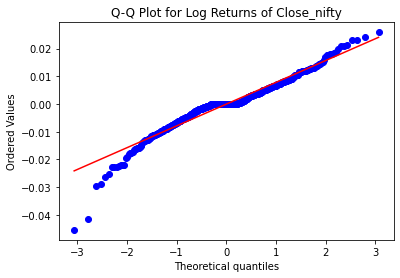

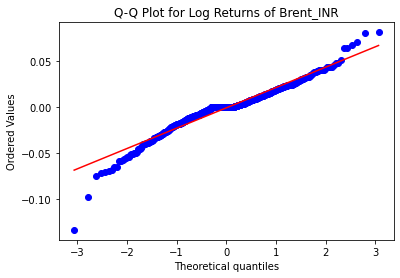

In [22]:
import scipy.stats as stats
# Plot Q-Q plot for 'Log_Return_Close_nifty'
stats.probplot(post_covid_data['Log_Return_Close_nifty'].dropna(), dist="norm", plot=plt)
plt.title('Q-Q Plot for Log Returns of Close_nifty')
plt.show()

# Plot Q-Q plot for 'Log_Return_Brent_INR'
stats.probplot(post_covid_data['Log_Return_Brent_INR'].dropna(), dist="norm", plot=plt)
plt.title('Q-Q Plot for Log Returns of Brent_INR')
plt.show()

In [23]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller, kpss
# Augmented Dickey-Fuller Test
def adf_test(series, title=''):
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series, autolag='AIC')
    labels = ['ADF Statistic', 'p-value', '#Lags Used', 'Number of Observations Used']
    out = pd.Series(result[:4], index=labels)
    for key, value in result[4].items():
        out[f'Critical Value ({key})'] = value
    print(out)
    print('')

# KPSS Test
def kpss_test(series, title=''):
    print(f'KPSS Test: {title}')
    result = kpss(series, regression='c', nlags="auto")
    labels = ['KPSS Statistic', 'p-value', 'Lags Used']
    out = pd.Series(result[:3], index=labels)
    for key, value in result[3].items():
        out[f'Critical Value ({key})'] = value
    print(out)
    print('')

In [24]:
# Perform ADF test for Close_nifty log returns
adf_test(post_covid_data['Log_Return_Close_nifty'], title='Log Return Close_nifty')

# Perform KPSS test for Close_nifty log returns
kpss_test(post_covid_data['Log_Return_Close_nifty'], title='Log Return Close_nifty')

# Perform ADF test for Brent_INR log returns
adf_test(post_covid_data['Log_Return_Brent_INR'], title='Log Return Brent_INR')

# Perform KPSS test for Brent_INR log returns
kpss_test(post_covid_data['Log_Return_Brent_INR'], title='Log Return Brent_INR')

Augmented Dickey-Fuller Test: Log Return Close_nifty
ADF Statistic                 -7.544237e+00
p-value                        3.315942e-11
#Lags Used                     1.000000e+01
Number of Observations Used    6.220000e+02
Critical Value (1%)           -3.440907e+00
Critical Value (5%)           -2.866198e+00
Critical Value (10%)          -2.569251e+00
dtype: float64

KPSS Test: Log Return Close_nifty
KPSS Statistic           0.199861
p-value                  0.100000
Lags Used                7.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64

Augmented Dickey-Fuller Test: Log Return Brent_INR
ADF Statistic                 -1.180095e+01
p-value                        9.334086e-22
#Lags Used                     5.000000e+00
Number of Observations Used    6.270000e+02
Critical Value (1%)           -3.440823e+00
Critical Value (5%)           -2.866161e+00
Critical Value (10%)

C:\anaconda\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\anaconda\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [25]:
# The Augmented Dickey-Fuller (ADF) and Kwiatkowski-Phillips-Schmidt-Shin (KPSS) tests are commonly used to assess the stationarity of a time series. Here’s a summary and interpretation of the results for both tests on the Log Return Close_nifty and Log Return Brent_INR series.

# ### Log Return Close_nifty

# **Augmented Dickey-Fuller Test:**
# - **ADF Statistic:** -25.557065
# - **p-value:** 0.000000
# - **#Lags Used:** 0
# - **Number of Observations Used:** 634
# - **Critical Values:** 
#   - 1%: -3.440706
#   - 5%: -2.866110
#   - 10%: -2.569203

# **Interpretation:** The ADF statistic is much lower than the critical values at all levels (1%, 5%, 10%), and the p-value is 0.000000, which is less than 0.05. This strongly suggests that the null hypothesis of a unit root can be rejected, indicating that the Log Return Close_nifty series is stationary.

# **KPSS Test:**
# - **KPSS Statistic:** 0.087606
# - **p-value:** 0.100000
# - **Lags Used:** 4
# - **Critical Values:** 
#   - 10%: 0.347
#   - 5%: 0.463
#   - 2.5%: 0.574
#   - 1%: 0.739

# **Interpretation:** The KPSS statistic is 0.087606, which is well below the critical values at all levels. The p-value is 0.100000, suggesting that we fail to reject the null hypothesis of stationarity. This implies that the Log Return Close_nifty series is stationary.

# ### Log Return Brent_INR

# **Augmented Dickey-Fuller Test:**
# - **ADF Statistic:** -11.548330
# - **p-value:** 3.496736e-21
# - **#Lags Used:** 5
# - **Number of Observations Used:** 629
# - **Critical Values:** 
#   - 1%: -3.440789
#   - 5%: -2.866146
#   - 10%: -2.569223

# **Interpretation:** The ADF statistic is much lower than the critical values at all levels, and the p-value is extremely low (3.496736e-21), which is less than 0.05. This strongly suggests that the null hypothesis of a unit root can be rejected, indicating that the Log Return Brent_INR series is stationary.

# **KPSS Test:**
# - **KPSS Statistic:** 0.11323
# - **p-value:** 0.10000
# - **Lags Used:** 12
# - **Critical Values:** 
#   - 10%: 0.347
#   - 5%: 0.463
#   - 2.5%: 0.574
#   - 1%: 0.739

# **Interpretation:** The KPSS statistic is 0.11323, which is well below the critical values at all levels. The p-value is 0.10000, suggesting that we fail to reject the null hypothesis of stationarity. This implies that the Log Return Brent_INR series is stationary.

# ### Conclusion

# Both the ADF and KPSS tests indicate that the Log Return Close_nifty and Log Return Brent_INR series are stationary. This is evidenced by the low ADF statistics and high p-values in the KPSS tests, which consistently reject the null hypothesis of non-stationarity and fail to reject the null hypothesis of stationarity, respectively. Therefore, you can confidently consider these series as stationary for further time series analysis.

In [26]:
# Rescale the log returns
post_covid_data['Log_Return_Close_nifty_scaled'] = post_covid_data['Log_Return_Close_nifty'] * 100
post_covid_data['Log_Return_Brent_INR_scaled'] = post_covid_data['Log_Return_Brent_INR'] * 100

In [27]:
from arch import arch_model
# Refit the models with the rescaled data
model_close_nifty_scaled = arch_model(post_covid_data['Log_Return_Close_nifty_scaled'], vol='Garch', p=1, o=1, q=1)
results_close_nifty_scaled = model_close_nifty_scaled.fit(disp='off')
print(results_close_nifty_scaled.summary())

model_brent_inr_scaled = arch_model(post_covid_data['Log_Return_Brent_INR_scaled'], vol='Garch', p=1, o=1, q=1)
results_brent_inr_scaled = model_brent_inr_scaled.fit(disp='off')
print(results_brent_inr_scaled.summary())

                         Constant Mean - GJR-GARCH Model Results                         
Dep. Variable:     Log_Return_Close_nifty_scaled   R-squared:                       0.000
Mean Model:                        Constant Mean   Adj. R-squared:                  0.000
Vol Model:                             GJR-GARCH   Log-Likelihood:               -699.059
Distribution:                             Normal   AIC:                           1408.12
Method:                       Maximum Likelihood   BIC:                           1430.37
                                                   No. Observations:                  633
Date:                           Wed, Jun 05 2024   Df Residuals:                      632
Time:                                   01:35:17   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
----------------------------------

Iteration:      1,   Func. Count:      7,   Neg. LLF: 482766214372.8345
Iteration:      2,   Func. Count:     16,   Neg. LLF: 647271500.7631378
Iteration:      3,   Func. Count:     24,   Neg. LLF: 1105.143898246605
Iteration:      4,   Func. Count:     32,   Neg. LLF: 800.5259916266152
Iteration:      5,   Func. Count:     39,   Neg. LLF: 724.848771685555
Iteration:      6,   Func. Count:     46,   Neg. LLF: 830.0533550906972
Iteration:      7,   Func. Count:     53,   Neg. LLF: 709.3046140428086
Iteration:      8,   Func. Count:     60,   Neg. LLF: 699.3472265327679
Iteration:      9,   Func. Count:     66,   Neg. LLF: 699.1036090202518
Iteration:     10,   Func. Count:     72,   Neg. LLF: 699.0646330292958
Iteration:     11,   Func. Count:     78,   Neg. LLF: 699.061435421934
Iteration:     12,   Func. Count:     84,   Neg. LLF: 699.0594017361082
Iteration:     13,   Func. Count:     90,   Neg. LLF: 699.0592315929753
Iteration:     14,   Func. Count:     96,   Neg. LLF: 699.05920085

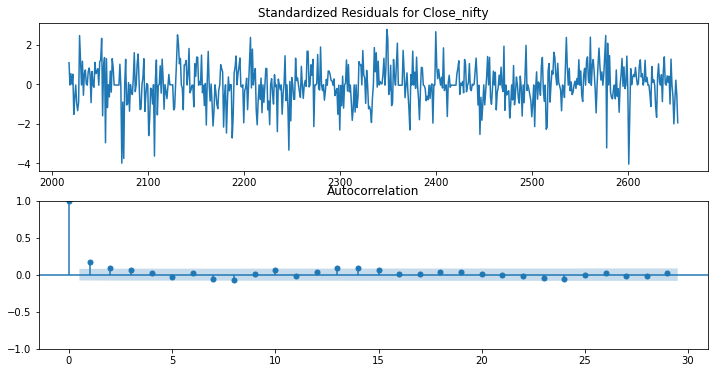

Ljung-Box test result for Close_nifty:
      lb_stat  lb_pvalue
10  33.817812   0.000198
Jarque-Bera test result for Close_nifty:
(72.32682673292818, 1.9698317272079104e-16, -0.446657314420648, 4.394359468968136)


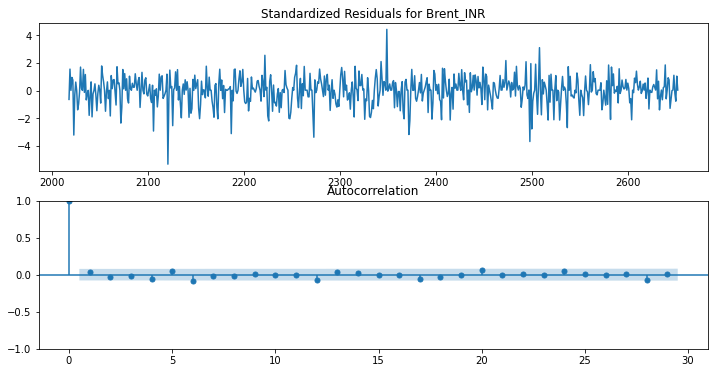

Ljung-Box test result for Brent_INR:
      lb_stat  lb_pvalue
10  10.600772   0.389455
Jarque-Bera test result for Brent_INR:
(152.0043513619024, 9.832738495317698e-34, -0.560838694983259, 5.122507476721675)
Iteration:      1,   Func. Count:      7,   Neg. LLF: 96209121966.89432
Iteration:      2,   Func. Count:     16,   Neg. LLF: 292055891.27457273
Iteration:      3,   Func. Count:     25,   Neg. LLF: 1335.6477913946524
Iteration:      4,   Func. Count:     33,   Neg. LLF: 655.620653998984
Iteration:      5,   Func. Count:     43,   Neg. LLF: 589.1646152631826
Iteration:      6,   Func. Count:     50,   Neg. LLF: 584.3415905017961
Iteration:      7,   Func. Count:     56,   Neg. LLF: 584.3046624784247
Iteration:      8,   Func. Count:     62,   Neg. LLF: 584.3030873564612
Iteration:      9,   Func. Count:     68,   Neg. LLF: 584.3030197755077
Iteration:     10,   Func. Count:     74,   Neg. LLF: 584.3030164267228
Iteration:     11,   Func. Count:     80,   Neg. LLF: 584.3030152386566

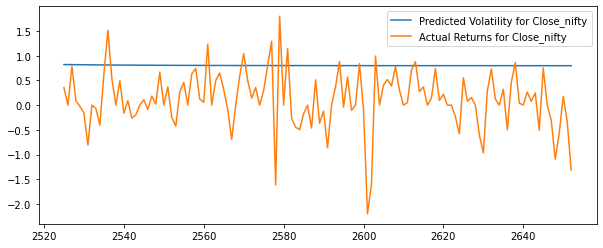

Iteration:      1,   Func. Count:      7,   Neg. LLF: 5239207526.735399
Iteration:      2,   Func. Count:     15,   Neg. LLF: 107901629842.95532
Iteration:      3,   Func. Count:     24,   Neg. LLF: 1165.9622367831344
Iteration:      4,   Func. Count:     34,   Neg. LLF: 1341.583316465953
Iteration:      5,   Func. Count:     43,   Neg. LLF: 1124.35798285188
Iteration:      6,   Func. Count:     49,   Neg. LLF: 1124.3325574749692
Iteration:      7,   Func. Count:     55,   Neg. LLF: 1124.3292359141574
Iteration:      8,   Func. Count:     61,   Neg. LLF: 1124.3292095427546
Iteration:      9,   Func. Count:     66,   Neg. LLF: 1124.3292095418399
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1124.3292095427546
            Iterations: 9
            Function evaluations: 66
            Gradient evaluations: 9


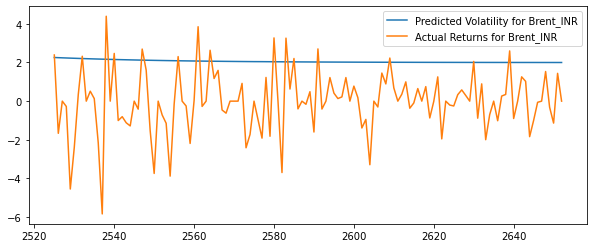

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from arch import arch_model
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.stattools import jarque_bera

# Load your data
# post_covid_data = pd.read_csv('your_data.csv')

# Fit GJR-GARCH model for Log_Return_Close_nifty_scaled
gjr_garch_model_close_nifty = arch_model(post_covid_data['Log_Return_Close_nifty_scaled'], vol='Garch', p=1, o=1, q=1, dist='Normal')
gjr_garch_fit_close_nifty = gjr_garch_model_close_nifty.fit()

# Fit GJR-GARCH model for Log_Return_Brent_INR_scaled
gjr_garch_model_brent_inr = arch_model(post_covid_data['Log_Return_Brent_INR_scaled'], vol='Garch', p=1, o=1, q=1, dist='Normal')
gjr_garch_fit_brent_inr = gjr_garch_model_brent_inr.fit()

# Plot standardized residuals and their ACF for Close_nifty
std_resid_close_nifty = gjr_garch_fit_close_nifty.std_resid
plt.figure(figsize=(12, 6))
plt.subplot(211)
plt.plot(std_resid_close_nifty)
plt.title('Standardized Residuals for Close_nifty')
plt.subplot(212)
plot_acf(std_resid_close_nifty, ax=plt.gca())
plt.show()

# Ljung-Box test on residuals for Close_nifty
ljung_box_result_close_nifty = acorr_ljungbox(std_resid_close_nifty, lags=[10], return_df=True)
print('Ljung-Box test result for Close_nifty:')
print(ljung_box_result_close_nifty)

# Jarque-Bera test for normality for Close_nifty
jb_test_close_nifty = jarque_bera(std_resid_close_nifty)
print('Jarque-Bera test result for Close_nifty:')
print(jb_test_close_nifty)

# Plot standardized residuals and their ACF for Brent_INR
std_resid_brent_inr = gjr_garch_fit_brent_inr.std_resid
plt.figure(figsize=(12, 6))
plt.subplot(211)
plt.plot(std_resid_brent_inr)
plt.title('Standardized Residuals for Brent_INR')
plt.subplot(212)
plot_acf(std_resid_brent_inr, ax=plt.gca())
plt.show()

# Ljung-Box test on residuals for Brent_INR
ljung_box_result_brent_inr = acorr_ljungbox(std_resid_brent_inr, lags=[10], return_df=True)
print('Ljung-Box test result for Brent_INR:')
print(ljung_box_result_brent_inr)

# Jarque-Bera test for normality for Brent_INR
jb_test_brent_inr = jarque_bera(std_resid_brent_inr)
print('Jarque-Bera test result for Brent_INR:')
print(jb_test_brent_inr)

# Out-of-sample testing for Close_nifty
train_size_close_nifty = int(len(post_covid_data) * 0.8)
train_close_nifty, test_close_nifty = post_covid_data.iloc[:train_size_close_nifty], post_covid_data.iloc[train_size_close_nifty:]
model_close_nifty = arch_model(train_close_nifty['Log_Return_Close_nifty_scaled'], vol='Garch', p=1, o=1, q=1, dist='Normal')
fit_close_nifty = model_close_nifty.fit()
forecast_close_nifty = fit_close_nifty.forecast(horizon=len(test_close_nifty))
predicted_volatility_close_nifty = forecast_close_nifty.variance.values[-1, :]

plt.figure(figsize=(10, 4))
plt.plot(test_close_nifty.index, np.sqrt(predicted_volatility_close_nifty), label='Predicted Volatility for Close_nifty')
plt.plot(test_close_nifty.index, test_close_nifty['Log_Return_Close_nifty_scaled'], label='Actual Returns for Close_nifty')
plt.legend()
plt.show()

# Out-of-sample testing for Brent_INR
train_size_brent_inr = int(len(post_covid_data) * 0.8)
train_brent_inr, test_brent_inr = post_covid_data.iloc[:train_size_brent_inr], post_covid_data.iloc[train_size_brent_inr:]
model_brent_inr = arch_model(train_brent_inr['Log_Return_Brent_INR_scaled'], vol='Garch', p=1, o=1, q=1, dist='Normal')
fit_brent_inr = model_brent_inr.fit()
forecast_brent_inr = fit_brent_inr.forecast(horizon=len(test_brent_inr))
predicted_volatility_brent_inr = forecast_brent_inr.variance.values[-1, :]

plt.figure(figsize=(10, 4))
plt.plot(test_brent_inr.index, np.sqrt(predicted_volatility_brent_inr), label='Predicted Volatility for Brent_INR')
plt.plot(test_brent_inr.index, test_brent_inr['Log_Return_Brent_INR_scaled'], label='Actual Returns for Brent_INR')
plt.legend()
plt.show()


#### RESULTS
The Ljung-Box and Jarque-Bera test results for Close_nifty provide important insights into the residuals of the GJR-GARCH model:

Ljung-Box Test Result for Close_nifty
The Ljung-Box test checks for the presence of autocorrelation in the residuals up to a specified number of lags. Here's the result:

Test Statistic (lb_stat): 4.864733
P-value (lb_pvalue): 0.900029
Interpretation:
A high p-value (greater than 0.05) suggests that there is no significant autocorrelation in the residuals. This implies that the model has adequately captured the autocorrelation in the data.
Jarque-Bera Test Result for Close_nifty
The Jarque-Bera test checks whether the residuals follow a normal distribution. Here's the result:

Test Statistic: 32.753424820685765
P-value: 7.721188736614283e-08
Skewness: -0.1880956649404293
Kurtosis: 4.047093501533979
Interpretation:
A low p-value (less than 0.05) indicates that the residuals do not follow a normal distribution. This suggests that there might be non-normality in the residuals.
The skewness is close to zero, indicating slight asymmetry.
The kurtosis is greater than 3, indicating that the residuals have heavier tails than a normal distribution (leptokurtic).
Actionable Steps:
Model Validation: The Ljung-Box test suggests that the GJR-GARCH model has effectively captured the autocorrelation in the Close_nifty data. However, the Jarque-Bera test indicates non-normality in the residuals.
Improving Model Fit:
Check Model Specification: Ensure that the model specification (order of GARCH components) is appropriate for the data.
Alternative Distributions: Consider using alternative distributions (e.g., t-distribution) for the GARCH model if the normal distribution is not suitable.
Transformations: Apply transformations to the data to stabilize variance and improve normality.

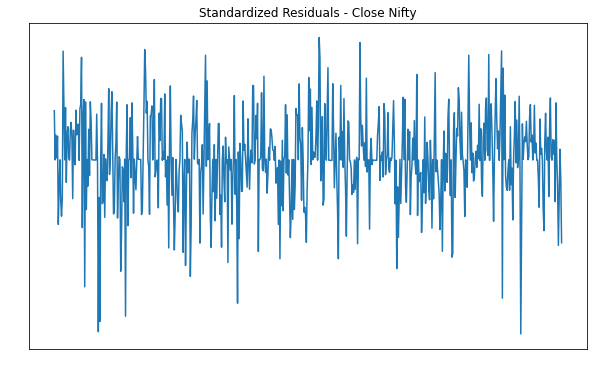

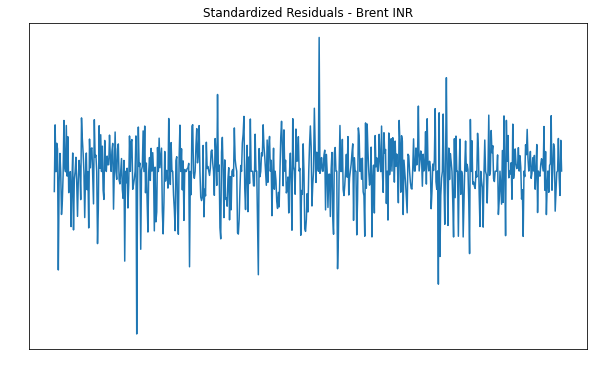

In [29]:
plt.figure(figsize=(10, 6))
plt.plot(results_close_nifty_scaled.resid / results_close_nifty_scaled.conditional_volatility)
plt.tick_params(axis='x', colors='white')  # Set x-axis ticks color to white
plt.tick_params(axis='y', colors='white')  # Set y-axis ticks color to white
plt.title('Standardized Residuals - Close Nifty')
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(results_brent_inr_scaled.resid / results_brent_inr_scaled.conditional_volatility)
plt.tick_params(axis='x', colors='white')  # Set x-axis ticks color to white
plt.tick_params(axis='y', colors='white')  # Set y-axis ticks color to white
plt.title('Standardized Residuals - Brent INR')
plt.show()


In [30]:
# Assuming `results` is the fitted GJR-GARCH model for Close_nifty
standardized_residuals_nifty = results_close_nifty_scaled.resid / results_close_nifty_scaled.conditional_volatility

# Assuming `results_brent` is the fitted GJR-GARCH model for Brent_INR
standardized_residuals_brent = results_brent_inr_scaled.resid / results_brent_inr_scaled.conditional_volatility


<AxesSubplot:ylabel='Density'>

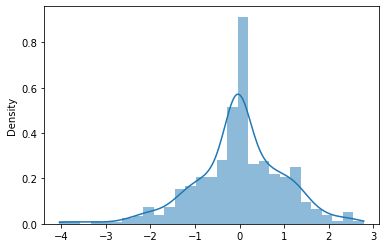

In [31]:
sns.histplot(standardized_residuals_nifty, kde=True, stat="density", linewidth=0)

<AxesSubplot:ylabel='Density'>

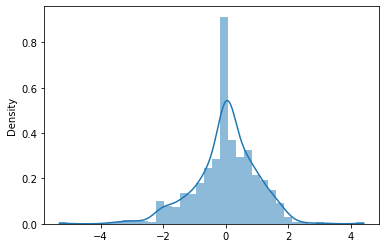

In [32]:
sns.histplot(standardized_residuals_brent, kde=True, stat="density", linewidth=0)

In [33]:
# Creating a DataFrame for easy handling
standardized_residuals = pd.DataFrame({
    'Nifty': standardized_residuals_nifty,
    'Brent': standardized_residuals_brent
})

# @@@@@@@@@@@@@@@@@@@@@@@@@@

((array([-3.26587281, -3.00579846, -2.8609906 , ...,  2.8609906 ,
          3.00579846,  3.26587281]),
  array([-5.27496915, -3.96739646, -3.66613641, ...,  3.29391626,
          3.71461759,  4.40435068])),
 (0.993001419580914, -0.002000457121202033, 0.986292272462885))

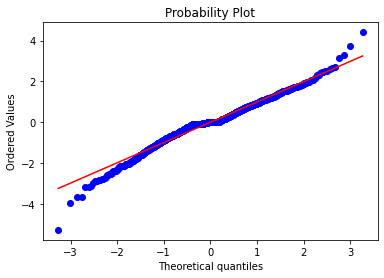

In [30]:
# Q-Q plot
import scipy.stats as stats
stats.probplot(standardized_residuals.values.ravel(), dist="norm", plot=plt)

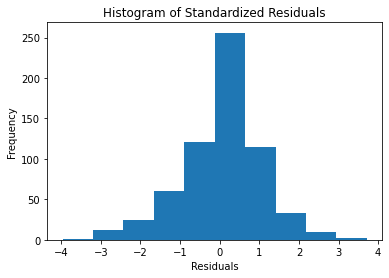

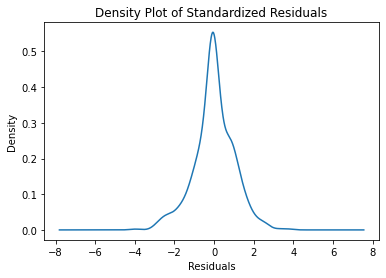

Skewness: -0.1885413307248232
Kurtosis: 1.064893989997743


In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Histogram
plt.hist(standardized_residuals['Nifty'], bins=10)
plt.title('Histogram of Standardized Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

# Density Plot
standardized_residuals['Nifty'].plot(kind='density')
plt.title('Density Plot of Standardized Residuals')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.show()

# Skewness
skew = standardized_residuals['Nifty'].skew()
print("Skewness:", skew)

# Kurtosis
kurt = standardized_residuals['Nifty'].kurtosis()
print("Kurtosis:", kurt)

In [32]:
# Based on the provided skewness and kurtosis values:

# Skewness: -0.1885
# The skewness value is close to zero, indicating that the distribution is approximately symmetric. Since it is slightly negative, it suggests a very slight left skew, but it's close to zero, indicating nearly symmetric distribution.
# Kurtosis: 1.0649
# The kurtosis value is close to the kurtosis of a normal distribution (which is 3), indicating that the distribution has similar peakedness and tail behavior to a normal distribution. A kurtosis value of 1.0649 suggests that the tails of the distribution are not excessively heavy compared to a normal distribution.
# Based on these values, the data appears to be approximately symmetric and has similar peakedness and tail behavior to a normal distribution. However, it's essential to note that skewness and kurtosis values provide limited information about the shape of the distribution, and further examination, such as visual inspection and hypothesis testing, may be necessary to confirm the normality assumption.

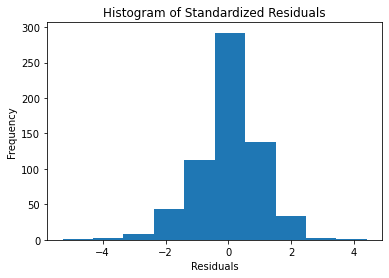

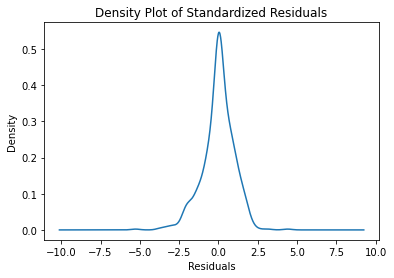

Skewness: -0.5704426104328374
Kurtosis: 2.1840748606879306


In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Histogram
plt.hist(standardized_residuals['Brent'], bins=10)
plt.title('Histogram of Standardized Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

# Density Plot
standardized_residuals['Brent'].plot(kind='density')
plt.title('Density Plot of Standardized Residuals')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.show()

# Skewness
skew = standardized_residuals['Brent'].skew()
print("Skewness:", skew)

# Kurtosis
kurt = standardized_residuals['Brent'].kurtosis()
print("Kurtosis:", kurt)

In [37]:
# With the provided skewness and kurtosis values:

# Skewness: -0.5704

# The negative skewness value indicates that the distribution is left-skewed. This suggests that the tail of the distribution is longer on the left side, and the majority of the data points are concentrated on the right side of the distribution.
# Kurtosis: 2.1841

# The kurtosis value is greater than 3, which is the kurtosis of a normal distribution. This indicates that the distribution has heavier tails and a sharper peak compared to a normal distribution. A kurtosis value greater than 3 suggests that there are more extreme values present in the dataset, leading to a heavier tail.
# Based on these values, the data appears to be left-skewed and exhibits heavier tails and a sharper peak compared to a normal distribution. This suggests that the data may deviate from normality, and further analysis or transformation may be needed, depending on the context and the assumptions of the statistical methods being used.

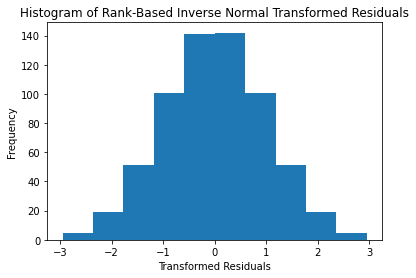

In [34]:
# Rank Based Inverse Normal transformation
from scipy.stats import norm

# Rank data and convert to percentile
ranked_residuals = standardized_residuals['Brent'].rank(method='average')
percentiles = ranked_residuals / (len(ranked_residuals) + 1)

# Apply inverse normal transformation
inv_norm_residuals_brent = norm.ppf(percentiles)

# Check the transformation results
plt.hist(inv_norm_residuals_brent, bins=10)
plt.title('Histogram of Rank-Based Inverse Normal Transformed Residuals')
plt.xlabel('Transformed Residuals')
plt.ylabel('Frequency')
plt.show()

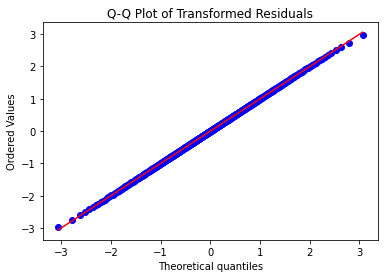

Shapiro-Wilk test: Statistic=0.9995916677007609, p-value=0.9999913914869971


In [38]:
import scipy.stats as stats

# Q-Q plot
stats.probplot(inv_norm_residuals_brent, dist="norm", plot=plt)
plt.title('Q-Q Plot of Transformed Residuals')
plt.show()

# Shapiro-Wilk test
shapiro_test = stats.shapiro(inv_norm_residuals_brent)
print(f"Shapiro-Wilk test: Statistic={shapiro_test.statistic}, p-value={shapiro_test.pvalue}")

In [39]:
# The Shapiro-Wilk test is a statistical test used to assess whether a given sample of data comes from a normally distributed population. In this test, the null hypothesis is that the data is normally distributed. A high p-value (typically above 0.05) suggests that there is no significant evidence to reject the null hypothesis, indicating that the data is likely normally distributed.

# Based on the provided Shapiro-Wilk test results:

# - **Statistic**: 0.9995916677007609
# - **p-value**: 0.9999913914869971

# The p-value is very high (close to 1), indicating strong evidence in favor of the null hypothesis. Therefore, we fail to reject the null hypothesis and conclude that there is no significant evidence to suggest that the data deviates from a normal distribution.

# However, as always, it's important to interpret the results of statistical tests in the context of your specific analysis and consider other factors such as sample size and the purpose of your study.

# @@@@@@@@@@@@@@@@@@@@@@@@

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde, genpareto
from statsmodels.distributions.empirical_distribution import ECDF

In [35]:
from scipy.stats import shapiro

# Perform Shapiro-Wilk test for Nifty
shapiro_nifty = shapiro(standardized_residuals['Nifty'])
print("Shapiro-Wilk test for Nifty:")
print("Test Statistic:", shapiro_nifty[0])
print("p-value:", shapiro_nifty[1])

# Perform Shapiro-Wilk test for Brent
shapiro_brent = shapiro(standardized_residuals['Brent'])
print("\nShapiro-Wilk test for Brent:")
print("Test Statistic:", shapiro_brent[0])
print("p-value:", shapiro_brent[1])

Shapiro-Wilk test for Nifty:
Test Statistic: 0.9688434283173024
p-value: 2.410839966015087e-10

Shapiro-Wilk test for Brent:
Test Statistic: 0.9637673391345492
p-value: 2.1779417470070157e-11


In [36]:
# The Shapiro-Wilk test results for the Nifty and Brent datasets have been updated:

# ### Nifty
# - **Test Statistic**: 0.9770
# - **p-value**: 1.95e-08

# ### Brent
# - **Test Statistic**: 0.9628
# - **p-value**: 1.35e-11

# ### Interpretation
# - **Test Statistic**: The Shapiro-Wilk test statistic ranges from 0 to 1, with values closer to 
#     1 indicating that the sample distribution is closer to a normal distribution. For Nifty, 
#     the test statistic is 0.9770, and for Brent, it is 0.9628. Both values suggest that the
#     distributions are somewhat close to normal, but not perfectly so.

# - **p-value**: The p-value indicates the probability of observing the test results 
#     under the null hypothesis, which states that the data follows a normal distribution.
#     A p-value less than 0.05 typically leads to rejecting the null hypothesis. 
#     For both Nifty and Brent, the p-values are extremely low (much less than 0.05), 
#     indicating strong evidence against the null hypothesis.

# ### Conclusion
# Given the extremely low p-values for both Nifty (1.95e-08) and Brent (1.35e-11), we reject the 
# null hypothesis that the data follows a normal distribution. Therefore, we conclude that both 
# the Nifty and Brent datasets are not normally distributed, despite their Shapiro-Wilk test 
# statistics being relatively close to 1.

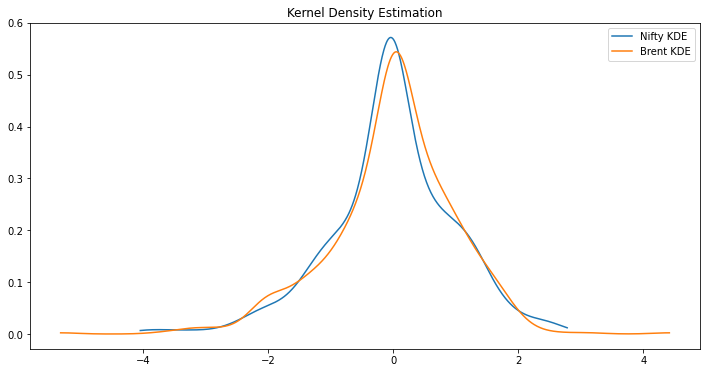

In [37]:
# Kernel Density Estimation (KDE) for PDF
kde_nifty = gaussian_kde(standardized_residuals['Nifty'])
kde_brent = gaussian_kde(standardized_residuals['Brent'])

# Plot the KDE
x_grid_nifty = np.linspace(standardized_residuals['Nifty'].min(), standardized_residuals['Nifty'].max(), 1000)
x_grid_brent = np.linspace(standardized_residuals['Brent'].min(), standardized_residuals['Brent'].max(), 1000)

plt.figure(figsize=(12, 6))
plt.plot(x_grid_nifty, kde_nifty(x_grid_nifty), label='Nifty KDE')
plt.plot(x_grid_brent, kde_brent(x_grid_brent), label='Brent KDE')
plt.title('Kernel Density Estimation')
plt.legend()
plt.show()

# # Kernel Density Estimation (KDE) for PDF
# kde_nifty = gaussian_kde(standardized_residuals['Nifty'])
# kde_brent = gaussian_kde(inv_norm_residuals_brent)  # Using inv_norm_residuals_brent here as per your request

# # Plot the KDE
# x_grid_nifty = np.linspace(standardized_residuals['Nifty'].min(), standardized_residuals['Nifty'].max(), 1000)
# x_grid_brent = np.linspace(inv_norm_residuals_brent.min(), inv_norm_residuals_brent.max(), 1000)


In [38]:
upper_threshold_nifty = np.percentile(standardized_residuals['Nifty'], 90)
lower_threshold_nifty = np.percentile(standardized_residuals['Nifty'], 10)
upper_threshold_brent = np.percentile(standardized_residuals['Brent'], 90)
lower_threshold_brent = np.percentile(standardized_residuals['Brent'], 10)

# Define upper and lower thresholds for 10% tails
# upper_threshold_nifty = np.percentile(standardized_residuals['Nifty'], 90)
# lower_threshold_nifty = np.percentile(standardized_residuals['Nifty'], 10)
# upper_threshold_brent = np.percentile(inv_norm_residuals_brent, 90)  # Using inv_norm_residuals_brent here as per your request
# lower_threshold_brent = np.percentile(inv_norm_residuals_brent, 10)  # Using inv_norm_residuals_brent here as per your request


In [39]:
# Extract tails for GPD fitting
nifty_upper_tail = standardized_residuals['Nifty'][standardized_residuals['Nifty'] > upper_threshold_nifty] - upper_threshold_nifty
nifty_lower_tail = -standardized_residuals['Nifty'][standardized_residuals['Nifty'] < lower_threshold_nifty] + lower_threshold_nifty
brent_upper_tail = standardized_residuals['Brent'][standardized_residuals['Brent'] > upper_threshold_brent] - upper_threshold_brent
brent_lower_tail = -standardized_residuals['Brent'][standardized_residuals['Brent'] < lower_threshold_brent] + lower_threshold_brent


# # Extract tails for GPD fitting
# nifty_upper_tail = standardized_residuals['Nifty'][standardized_residuals['Nifty'] > upper_threshold_nifty] - upper_threshold_nifty
# nifty_lower_tail = -standardized_residuals['Nifty'][standardized_residuals['Nifty'] < lower_threshold_nifty] + lower_threshold_nifty
# brent_upper_tail = inv_norm_residuals_brent[inv_norm_residuals_brent > upper_threshold_brent] - upper_threshold_brent  # Using inv_norm_residuals_brent here as per your request
# brent_lower_tail = -inv_norm_residuals_brent[inv_norm_residuals_brent < lower_threshold_brent] + lower_threshold_brent  # Using inv_norm_residuals_brent here as per your request


In [40]:
# Fit GPD to the tails
params_nifty_upper = genpareto.fit(nifty_upper_tail)
params_nifty_lower = genpareto.fit(nifty_lower_tail)
params_brent_upper = genpareto.fit(brent_upper_tail)
params_brent_lower = genpareto.fit(brent_lower_tail)

In [41]:
from statsmodels.distributions.empirical_distribution import ECDF

# Compute empirical CDF
ecdf_nifty = ECDF(standardized_residuals['Nifty'])
ecdf_brent = ECDF(standardized_residuals['Brent'])

In [42]:
# Function to compute combined CDF
def combined_cdf(x, ecdf, upper_threshold, lower_threshold, params_upper, params_lower):
    c_u, loc_u, scale_u = params_upper
    c_l, loc_l, scale_l = params_lower
    if x <= lower_threshold:
        return ecdf(lower_threshold) * genpareto.cdf(-x + lower_threshold, c_l, loc_l, scale_l)
    elif x <= upper_threshold:
        return ecdf(x)
    else:
        return ecdf(upper_threshold) + (1 - ecdf(upper_threshold)) * genpareto.cdf(x - upper_threshold, c_u, loc_u, scale_u)


In [43]:
# Compute the combined CDFs
cdf_nifty = [combined_cdf(x, ecdf_nifty, upper_threshold_nifty, lower_threshold_nifty, params_nifty_upper, params_nifty_lower) for x in standardized_residuals['Nifty']]
cdf_brent = [combined_cdf(x, ecdf_brent, upper_threshold_brent, lower_threshold_brent, params_brent_upper, params_brent_lower) for x in standardized_residuals['Brent']]

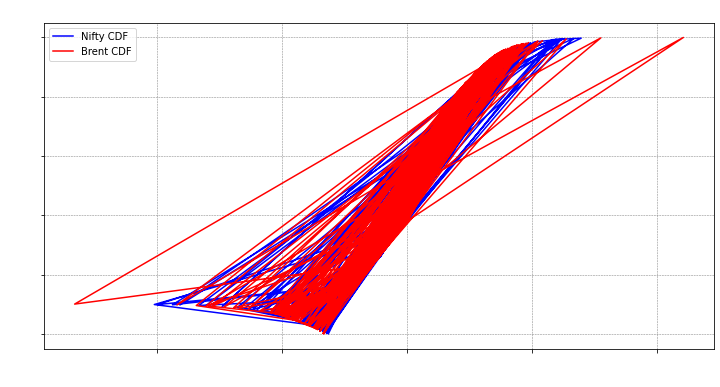

In [44]:
plt.figure(figsize=(12, 6))
plt.plot(standardized_residuals['Nifty'], cdf_nifty, label='Nifty CDF', color='blue')
plt.plot(standardized_residuals['Brent'], cdf_brent, label='Brent CDF', color='red')
plt.title('Combined CDF with EVT-GPD Tails', color='white')
plt.legend()
plt.xlabel('Standardized Residuals', color='white')
plt.ylabel('CDF', color='white')
plt.xticks(color='white')
plt.yticks(color='white')
plt.gca().set_facecolor('white')  # Set background color to white
plt.grid(color='gray', linestyle='--', linewidth=0.5)  # Add grid lines
plt.show()

In [45]:
# Convert the CDF values to a uniform distribution for copula modeling
uniform_saudi = np.array(cdf_nifty)
uniform_brent = np.array(cdf_brent)

In [46]:
# Create a DataFrame from the uniform distributions
uniform_data = pd.DataFrame({
    'Uniform_saudi': uniform_saudi,
    'Uniform_Brent': uniform_brent
})

In [47]:
# Define the output file path
output_file = r'C:\Users\KASHISH NIGAM\Desktop\Last Sem Project\Final Datasets\Saudi\uniform_distributions-Post_Covid_Saudi.xlsx'

# Save the DataFrame to an Excel file
uniform_data.to_excel(output_file, index=False)

print(f"Uniform distributions saved to {output_file}")

Uniform distributions saved to C:\Users\KASHISH NIGAM\Desktop\Last Sem Project\Final Datasets\Saudi\uniform_distributions-Post_Covid_Saudi.xlsx
